# Escola de Matemática Aplicada - FGV

Aluno: Igor  da Silva Carvalho
-----
Matéria: Sistema de Recuperação de Informações
-----
Professor: Flávio Coelho
----
Lista de Exercício 2 - SRI
---

Pacotes que serão utilizados ao longo deste notebook.

In [1]:
from nltk.corpus import machado
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from numpy.linalg import norm

import os
import pandas as pd
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt

from gensim import corpora, models, similarities
from nltk.stem.snowball import PortugueseStemmer
from collections import Counter
from string import punctuation

from collections import defaultdict
from nltk.stem.snowball import PortugueseStemmer
import nltk
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [291]:
os.getcwd()

'/home/igor/Gitlab/IR_Exercises'

# Questão 1
_____________________

Importando os textos de Machado de Assis. 

Cada entrada da lista *textos* corresponde a uma das obras de Machado de Assis. Já lista *titulos* contém os títulos destas obras.

In [423]:
textos = [machado.raw(id) for id in machado.fileids()]
titulos = [textos[i].split('\n')[0] for i in range(len(textos))]
print(len(textos))
print(titulos[0:4])

246
['Conto, Contos Fluminenses, 1870', 'Conto, Historias da Meia-Noite, 1873', 'Conto, Papéis Avulsos, 1882', 'Conto, Histórias sem Data, 1884']


A lista *tok_textos* contém as obras de Machado de Assis já tokenizadas e unformizadas para caixa baixa.

In [424]:
tok_textos = [WordPunctTokenizer().tokenize(t.lower()) for t in textos]
#len(tok_textos)

A seguir é criado uma coleção de textos com os quais calcularemos as métricas *tf* e *tf-idf*, comforme solicitado no enunciado.

In [425]:
colecao_machado = nltk.TextCollection(tok_textos)

A seguir vamos definir uma consulta, calcular os índices *tf* e *tf_idf* e a similaridade por cossenos para recuperar as obras que fazem referência a consulta.

In [426]:
q = "quincas barbacena cachorro chuva padre"

A função a seguir calcula o tf dos termos da consulta em cada documento e os organiza em uma matriz.

In [427]:
def matriz_tf_normalizada(q):
    qt = WordPunctTokenizer().tokenize(q.lower())
    matriz_tf = np.empty((len(tok_textos),len(qt)))
    for j,w in enumerate(qt):
        for i, d in enumerate(tok_textos):
            matriz_tf[i,j] = colecao_machado.tf(w,d)
    #print(matriz_tf.shape)
    matriz_tf_norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in matriz_tf])
    #matriz_tf_norm[:3,:]
    return(matriz_tf_norm)

In [428]:
m_tf_norm = matriz_tf_normalizada(q)
m_tf_norm[:3,:]

array([[0.        , 0.        , 0.08543577, 0.51261459, 0.85435766],
       [0.        , 0.        , 0.        , 0.14142136, 0.98994949],
       [0.        , 0.        , 0.        , 0.02855977, 0.99959209]])

A função a seguir calcula o tfidf dos termos da consulta em cada documento e os organiza em uma matriz.

In [429]:
def matriz_tfidf_normalizada(q):
    qt = WordPunctTokenizer().tokenize(q.lower())
    matriz_tfidf = np.empty((len(tok_textos),len(qt)))
    for j,w in enumerate(qt):
        for i, d in enumerate(tok_textos):
            matriz_tfidf[i,j] = colecao_machado.tf_idf(w,d)
    #print(matriz_tfidf.shape)
    matriz_tfidf_norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in matriz_tfidf])
    #matriz_tfidf_norm[:3,:]
    return(matriz_tfidf_norm)

In [430]:
m_tfidf_norm = matriz_tfidf_normalizada(q)
m_tfidf_norm[:3,:]

array([[0.        , 0.        , 0.20161222, 0.52090293, 0.82946528],
       [0.        , 0.        , 0.        , 0.14787949, 0.98900539],
       [0.        , 0.        , 0.        , 0.02989133, 0.99955315]])

Similar ao apresentado nos slides, mas com as colunas e linhas invertidas.

Já vimos que a similaridade entre dois cossenos é dada por:

$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

Vamos calcular a norma L2 da matriz de tf-idf:
$||A||_F = \sqrt{\sum_{i} |A_{i}|^2}$

A funções a seguir normalizam as consultas.

In [431]:
def tf_consulta_normalizada(q):
    qt = WordPunctTokenizer().tokenize(q.lower())
    qn = np.array([colecao_machado.tf(w,qt) for w in qt])
    qn /= norm(qn)
    return(qn)

def tfidf_consulta_normalizada(q):
    qt = WordPunctTokenizer().tokenize(q.lower())
    qn = np.array([colecao_machado.tf_idf(w,qt) for w in qt])
    qn /= norm(qn)
    return(qn)

In [432]:
qn_tf = tf_consulta_normalizada(q)
qn_tfidf = tfidf_consulta_normalizada(q)

In [434]:
qn_tfidf

array([0.63117935, 0.58997432, 0.43261885, 0.18629197, 0.17798639])

Enfim, a função abaixo calcula a similiridade por cossenos entre o vetor consulta e a matriz tf(ou tf-idf) normalizada.

In [13]:
def sim_cossenos(q, matriz_normalizada):
    sim_coss = [np.dot(q,r) for r in matriz_normalizada]
    sim_coss_filtrada = filter(lambda x : x[0]!=0.0, zip(sim_coss, titulos))
    resposta = sorted(sim_coss_filtrada, reverse=True) 
    return(resposta)

Calculando a similaridade por cossenos com as métricas tf e tf-idf.

In [14]:
teste1 = sim_cossenos(qn_tf, m_tf_norm)
print("Similaridade por cossenos com a métrica tf: ")
teste1

Similaridade por cossenos com a métrica tf: 


[(0.816593488717626, 'ROMANCE, Quincas Borba,1891'),
 (0.7302967433402214, 'POESIA, Gazeta de Holanda, 1886'),
 (0.7171371656006361, 'Poesia, Crisálidas, 1864'),
 (0.6662098891778447, 'CRÔNICA, Balas de estalo,1883'),
 (0.6495366119157395, 'Conto, Contos Fluminenses, 1870'),
 (0.6377655616314124, 'Crônica, A semana, 1892'),
 (0.6324555320336759, 'Crítica, A nova geração, 1879'),
 (0.6324555320336759, 'Conto, Decadência de dois grandes homens, 1873'),
 (0.6324555320336758, 'Conto, O último dia de um poeta, 1867'),
 (0.6310547428675068, 'ROMANCE, Esaú e Jacó,1904'),
 (0.6285872661926204, 'CRÔNICA. Cronicas (O Futuro), 1862'),
 (0.6201736729460422, 'CRÔNICA.  Historia de quinze dias, 1876'),
 (0.610170215847752, 'CRÔNICA. Cronicas do Dr. Semana, 1861'),
 (0.6000000000000001, 'Poesia, Poesias dispersas, 1855-1939'),
 (0.6, 'TEATRO, O caminho da porta - O protocolo, 1863'),
 (0.6, 'Conto, Virginius, 1864'),
 (0.6, 'Conto, O imortal, 1882'),
 (0.5902918298980975, 'CRÔNICA, Ao Acaso, 1864.htm

In [15]:
teste2 = sim_cossenos(qn_tfidf, m_tfidf_norm)
print("Similaridade por cossenos com a métrica tf-idf: ")
teste2

Similaridade por cossenos com a métrica tf-idf: 


[(0.8760353367147004, 'ROMANCE, Quincas Borba,1891'),
 (0.6527293167058454, 'Romance, Memórias Póstumas de Brás Cubas, 1880'),
 (0.620669577942538, 'Poesia, Crisálidas, 1864'),
 (0.4819837081732777, 'POESIA, Gazeta de Holanda, 1886'),
 (0.4326188507574194, 'Conto, Vidros quebrados, 1883'),
 (0.4326188507574194, 'Conto, Terpsícore, 1886'),
 (0.3700537192920909, 'Crônica, A semana, 1892'),
 (0.33586034987386326, 'CRÔNICA, Balas de estalo,1883'),
 (0.33189481491835715, 'Conto, Contos Fluminenses, 1870'),
 (0.31917687264885675, 'CRÔNICA, Ao Acaso, 1864.htm'),
 (0.2836884547541149, 'ROMANCE, Memorial de Aires,1908'),
 (0.25765064670700627, 'Conto, Decadência de dois grandes homens, 1873'),
 (0.2576506467070062, 'Crítica, A nova geração, 1879'),
 (0.2576506467070062, 'Conto, O último dia de um poeta, 1867'),
 (0.2571168799645348, 'Conto, Páginas Recolhidas, 1899'),
 (0.2570777077780661, 'ROMANCE, Esaú e Jacó,1904'),
 (0.25609369494223405, 'CRÔNICA. Cronicas (O Futuro), 1862'),
 (0.2527445909

Observe que, excluindo o primeiro termo dos ranks acima, o rankeamento das obras se modificam consideravelmente ao utilizarmos a métrica *tf-idf*.

# Questão 2
_____________________

Neste item vamos definir todo o vocabulário dos textos de Machado de Assis como objeto de consulta.

O vocabulário diz respeito ao conjunto de todas as palavras presentes nas obras de Machado de Assis.

In [16]:
vocab = set([])
for t in tok_textos:
    vocab = vocab.union(set(t))
q = list(vocab)

A seguir calculamos o tfidf dos termos da consulta, definida acima, em cada documento e os organizamos em uma matriz.

In [17]:
#%%time
#matriz_tfidf = np.empty((len(tok_textos),len(q)))
#for j, w in enumerate(q):
#    for i, d in enumerate(tok_textos):
#        matriz_tfidf[i,j] = colecao_machado.tf_idf(w,d)
#    if j % 50 == 0:
#        print(j)
#print(matriz_tfidf.shape)
#matriz_tfidf_normalizada_vocab = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in matriz_tfidf])
#matriz_tfidf_norm[:3,:]

O código acima demora aproximadamente 1h e 14m para ser executado.
A seguir, vamos carregar o resultado do código acima que foi previamente exercutado e salvo no formato pickle.

In [18]:
file  = open('dados_questao2_lista2.pickle', 'rb')
matriz_tfidf_normalizada_vocab = pk.load(file)

Calculando a similaridade entre os textos de Machado de Assis.

In [19]:
matriz_similaridades_machado = np.empty((len(tok_textos),len(tok_textos)))
for i in range(len(tok_textos)):
    for j in range(len(tok_textos)):
        matriz_similaridades_machado[i, j] = np.dot(matriz_tfidf_normalizada_vocab[i], matriz_tfidf_normalizada_vocab[j])    

In [20]:
matriz_similaridades_machado

array([[1.        , 0.07753284, 0.16104791, ..., 0.01491274, 0.04305784,
        0.02140373],
       [0.07753284, 1.        , 0.079001  , ..., 0.37178505, 0.02557697,
        0.56339842],
       [0.16104791, 0.079001  , 1.        , ..., 0.0111284 , 0.05619913,
        0.02545718],
       ...,
       [0.01491274, 0.37178505, 0.0111284 , ..., 1.        , 0.00492258,
        0.39452797],
       [0.04305784, 0.02557697, 0.05619913, ..., 0.00492258, 1.        ,
        0.01333805],
       [0.02140373, 0.56339842, 0.02545718, ..., 0.39452797, 0.01333805,
        1.        ]])

Transformando os dados da matriz *matriz_similaridades_machado* para gerar o histograma.

In [21]:
dados_histograma = set(matriz_similaridades_machado[(matriz_similaridades_machado>0) & (matriz_similaridades_machado<1)])

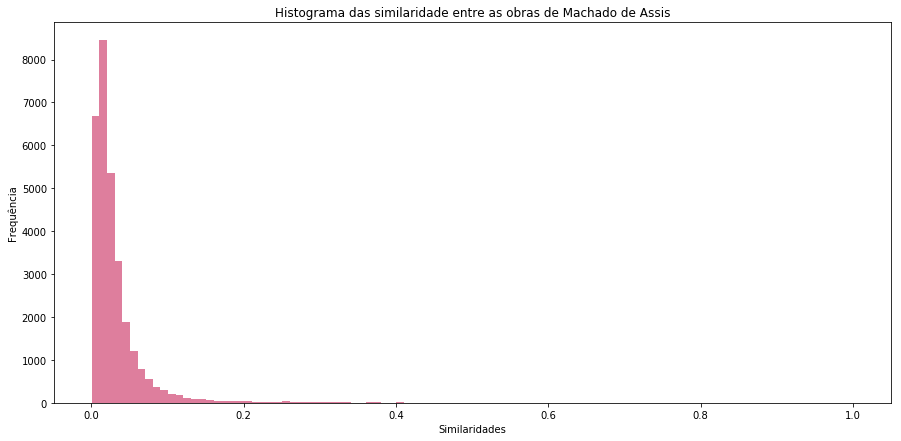

In [22]:
plt.figure(figsize = (15, 7))
plt.hist(list(dados_histograma), bins = 100, color = 'palevioletred', alpha =  0.9)
plt.title('Histograma das similaridade entre as obras de Machado de Assis')
plt.ylabel('Frequência')
plt.xlabel("Similaridades")
plt.show()

Podemos observar que não há muita similaridade entre os texto de Machado de Assis, visto que a maior incidência de similaridades ocorre para valores inferiores a 0,2.

Tansformando os dados da matriz *matriz_similaridades_machado* para gerar um heatmap das similaridades.

In [23]:
dados_heatmap = pd.DataFrame(matriz_similaridades_machado, columns=titulos, index=titulos)

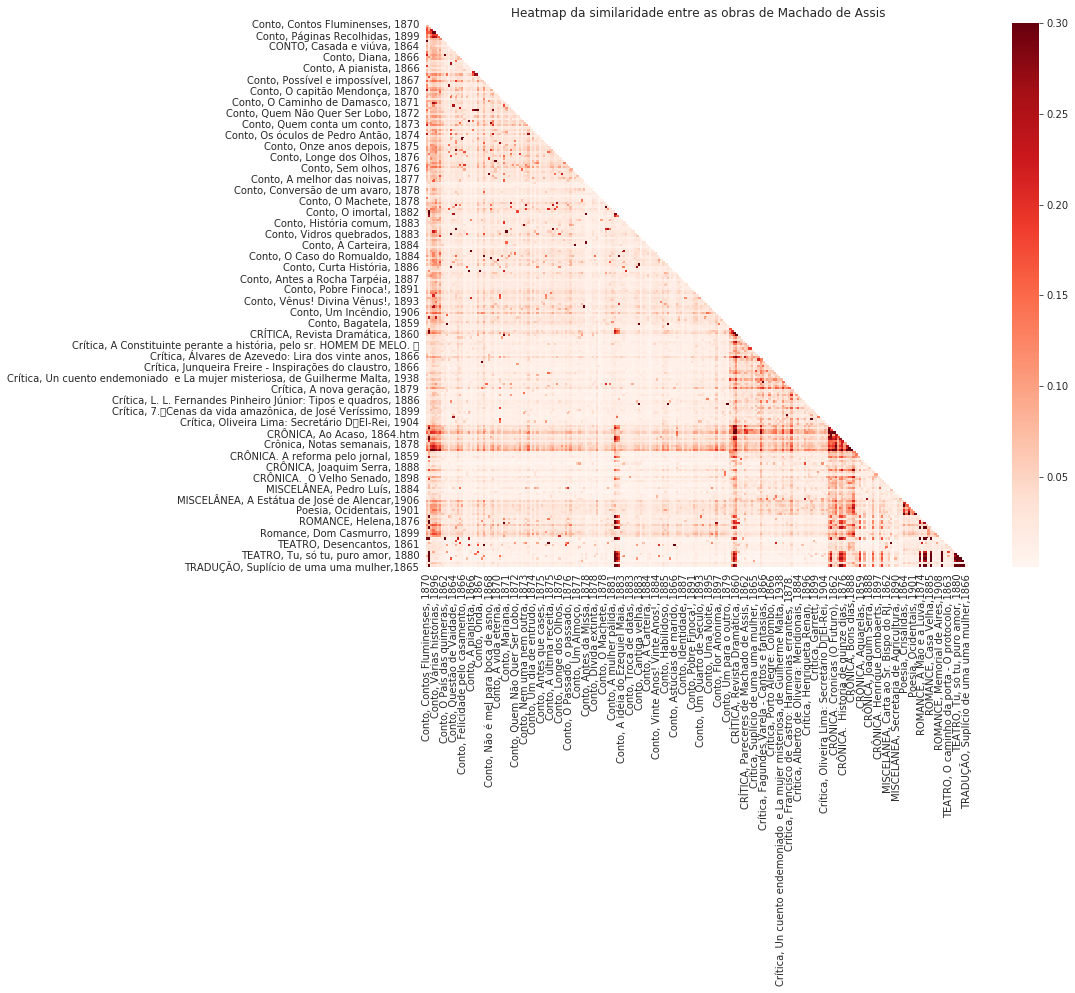

In [24]:
mask = np.zeros_like(dados_heatmap)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize = (15,10))
    ax = sns.heatmap(dados_heatmap, cmap = 'Reds', mask=mask, vmax=.3, square=True)
    plt.title('Heatmap da similaridade entre as obras de Machado de Assis')
    #ax.figure(figsize = (15, 8))

O *heatmap* acima apresenta uma visualização alternativa para a análise da similaridade entre as obras de Machado de Assis.

# Questão 3
-------


A seguir vamos criar um corpus para as obras de Machado de Assis. Para isto vamos utilizar o Gensim, uma biblioteca em Python para modelagem de assuntos.

Definindo o conjunto de *stop words*.

In [404]:
other_symbols = [""]
sw = stopwords.words('portuguese') + list(punctuation) + other_symbols
stemmer = PortugueseStemmer()

Para cada uma das obras de Machado de Assis contidas a lista *textos* vamos tokenizar, normalizar e remover *stopwords*.

Além disso, para cada um dos textos já tokenizados e limpos, vamos eliminar as palavras que aparecem uma única vez.

In [405]:
textos_limpos = []
c = Counter([])
for texto in textos:
    tlimpo = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in sw]
    c.update(tlimpo)
    textos_limpos.append(tlimpo)
textos_limpos = [[token for token in t if c[token]>1] for t in textos_limpos]

In [406]:
#textos_limpos[0]

A seguir, utilizamos os métodos do *gensim* para criar um dicionário com as palavras dos textos já limpos.

In [407]:
dicionario = corpora.Dictionary(textos_limpos)
print(len(dicionario))
print('\n')
print(dicionario)

18033


Dictionary(18033 unique tokens: ['', 'côv', 'glór', 'anticrist', 'duzent']...)


Identificando 'bad_ids':

In [408]:
bad_ids = []
for d in range(len(dicionario)):
    if ("\x97" in dicionario[d]) or (dicionario[d] == "\x97") or (dicionario[d] == "") or ("\x93" in dicionario[d]) or (dicionario[d] == "\x93"):
        bad_ids.append(d)

bad_ids

[0, 3934, 3936, 10541, 17459]

Removendo as 'bad_ids' do dicionário.

In [409]:
dicionario.filter_tokens(bad_ids=bad_ids)
print('Número de palavras após remoção das "bad_ids":' + str(len(dicionario)))

Número de palavras após remoção das "bad_ids":18028


Salvando o dicionário:

In [411]:
dicionario.save('vocabulario.dict')

Este dicionário contém o conjunto das palavras que aparecem pelo menos duas vezes em *textos_limpos*.

A seguir, construiremos o corpus utilizadno do método *doc2bow*. Este método recebe um conjunto de *tokens*, e retorna o índice destes dentro do dicionário, caso de fato existam no dicionário, e número de vezes que estes *tokens* aparecem no conjunto de *tokens* entregues como input. 

In [413]:
corpus = [dicionario.doc2bow(d) for d in textos_limpos]

In [414]:
corpora.MmCorpus.serialize('machado.mm', corpus)

In [415]:
corpus[3]

[(3, 1),
 (4, 2),
 (6, 1),
 (12, 154),
 (14, 3),
 (15, 7),
 (16, 5),
 (17, 4),
 (18, 4),
 (19, 3),
 (20, 5),
 (22, 4),
 (23, 12),
 (24, 5),
 (25, 12),
 (26, 2),
 (27, 1),
 (31, 1),
 (32, 6),
 (34, 17),
 (36, 1),
 (37, 1),
 (39, 8),
 (40, 1),
 (41, 2),
 (42, 48),
 (43, 21),
 (45, 6),
 (47, 10),
 (50, 21),
 (52, 8),
 (53, 4),
 (54, 1),
 (55, 1),
 (57, 3),
 (59, 2),
 (60, 2),
 (61, 18),
 (63, 1),
 (64, 1),
 (66, 11),
 (67, 4),
 (68, 6),
 (69, 31),
 (70, 2),
 (72, 8),
 (74, 1),
 (75, 2),
 (76, 12),
 (78, 18),
 (79, 9),
 (80, 4),
 (81, 5),
 (83, 14),
 (84, 8),
 (85, 2),
 (86, 1),
 (88, 7),
 (89, 2),
 (90, 9),
 (92, 10),
 (94, 13),
 (95, 3),
 (96, 2),
 (97, 1),
 (98, 1),
 (99, 6),
 (100, 1),
 (101, 3),
 (102, 1),
 (103, 1),
 (104, 1),
 (106, 12),
 (107, 5),
 (108, 12),
 (111, 4),
 (112, 1),
 (115, 7),
 (116, 3),
 (117, 3),
 (118, 2),
 (120, 1),
 (121, 2),
 (122, 16),
 (124, 12),
 (125, 6),
 (126, 2),
 (128, 2),
 (132, 4),
 (133, 11),
 (134, 44),
 (135, 1),
 (137, 2),
 (138, 8),
 (139, 3),
 (

# Questão 4
---------------

Com base nos resultados da questão anterior vamos ajustar um modelo LSI para os documentos de Machado de Assis.

In [416]:
lsi = models.LsiModel(corpus, id2word=dicionario, num_topics=4)

In [417]:
index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

/home/igor/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Definindo uma consulta.

Além disso, vamos converter a consulta para o espaço LSI.

In [418]:
q = "capitu olhos de ressaca e bentinho"
#q = "padre Melquior helena"

In [419]:
qt = [stemmer.stem(t) for t in WordPunctTokenizer().tokenize(q.lower())]
print(qt)
vec_bow = dicionario.doc2bow(qt)
vec_lsi = lsi[vec_bow]  
vec_lsi

['capitu', 'olhos', 'de', 'ressac', 'e', 'bentinh']


[(0, 0.1467293524268001),
 (1, -0.26236254963399125),
 (2, -0.05883211566096787),
 (3, -0.08751978966796908)]

Calculando a similaridade da consulta contra o corpus.

In [420]:
#sims = index[vec_lsi]
# print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples
def similaridade_corpus_consulta(q):
    qt = [stemmer.stem(t) for t in WordPunctTokenizer().tokenize(q.lower())]
    vec_bow = dicionario.doc2bow(qt)
    vec_lsi = lsi[vec_bow]
    sims = [(titulos[i], j) for i, j in enumerate(index[vec_lsi])]#index[vec_lsi]
    sims.sort(key=lambda item: -item[1])
    return(sims)

In [421]:
similaridade_corpus_consulta(q = q)

[('Conto, O Caso da Viúva, 1881', 0.8109229),
 ('Conto, Folha Rota, 1878', 0.8073998),
 ('Conto, Viagem à roda de mim mesmo, 1885', 0.8045615),
 ('Conto, Encher tempo, 1876', 0.7988212),
 ('Conto, A Carteira, 1884', 0.7956574),
 ('Conto, A Herança, 1878', 0.7878521),
 ('Conto, Sales, 1887', 0.78199005),
 ('Conto, Curta História, 1886', 0.7816982),
 ('Conto, Uma Carta, 1884', 0.78004575),
 ('Conto, Silvestre, 1877', 0.77908325),
 ('Conto, Miloca, 1874', 0.7767257),
 ('ROMANCE, Iaiá Garcia,1878', 0.776207),
 ('Conto, Astúcias de marido, 1866', 0.7753126),
 ('Conto, A pianista, 1866', 0.7741277),
 ('Conto, Dona Jucunda, 1889', 0.7737557),
 ('Conto, Onze anos depois, 1875', 0.7733971),
 ('Conto, Cantiga velha, 1883', 0.7723846),
 ('Conto, Mariana, 1871', 0.77166945),
 ('Conto, Um Sonho e Outro Sonho, 1892', 0.77128696),
 ('Conto, Uma Partida, 1892', 0.76941264),
 ('Conto, Uma Noite, 1895', 0.7666315),
 ('ROMANCE, Helena,1876', 0.7628354),
 ('Conto, Só, 1885', 0.76179594),
 ('Conto, Três co

In [422]:
lsi.show_topics()

[(0,
  '0.528*"é" + 0.225*"outr" + 0.187*"a" + 0.180*"nã" + 0.169*"o" + 0.156*"pod" + 0.156*"tod" + 0.126*"cas" + 0.120*"diz" + 0.108*"ser"'),
 (1,
  '0.461*"é" + -0.323*"diss" + -0.168*"mar" + -0.156*"mã" + -0.139*"cas" + -0.132*"olhos" + -0.124*"gilliatt" + -0.123*"capítul" + -0.118*"o" + -0.109*"a"'),
 (2,
  '0.391*"gilliatt" + 0.327*"o" + 0.217*"a" + 0.162*"mar" + 0.153*"águ" + 0.146*"lethierry" + 0.137*"vent" + -0.136*"diss" + -0.125*"nã" + -0.125*"outr"'),
 (3,
  '0.424*"sr" + 0.398*"oliv" + 0.382*"diss" + -0.187*"rubiã" + -0.174*"mar" + 0.160*"jud" + 0.141*"sik" + 0.133*"bumbl" + -0.133*"outr" + 0.128*"é"')]